In [1]:
from matplotlib.pyplot import figure, show, subplots
from matplotlib import pyplot as plt
import numpy as np
import random
from scipy.optimize import curve_fit
import csv
from scipy.stats import mannwhitneyu

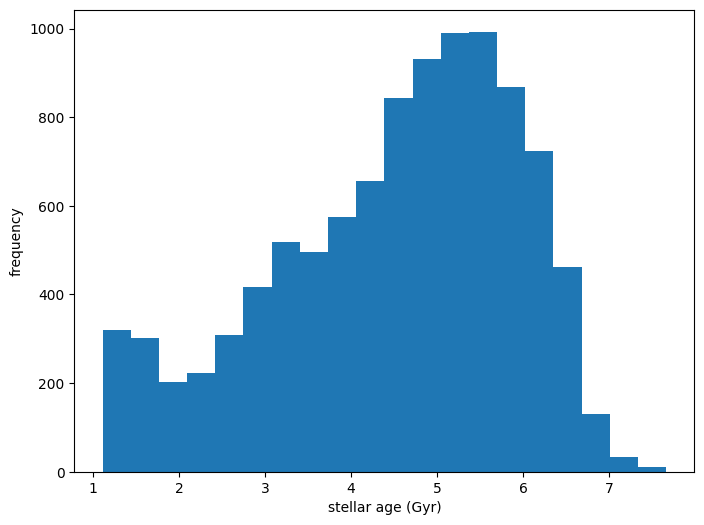

In [2]:
# generate stellar ages for p-pop

agebin = [7.664974490130835, 7.421319890726927, 7.162436399602606, 6.903553257029316, 6.6446701144560265, 6.416243709670467, 6.157360567097177, 5.8908626301126485, 5.654822476568947, 5.403553431304832, 5.137055494320302, 4.885786449056187, 4.64213184965228, 4.383248358527958, 4.131979313263843, 3.873096519241585, 3.6446701144560265, 3.3705584287133554, 3.1269031322073815, 2.860405892324918, 2.6319794875393585, 2.373095996415036, 2.121826951150921, 1.8629441571286645, 1.6192888606226905, 1.3756342612187824, 1.109137021336319]
frequency = [0.031153597012442847, 0.15576370689728483, 0.311527413794575, 0.8099692793889274, 2.4610600091242563, 5.700935700625, 10.74766440270338, 13.925233613206725, 13.457943918569839, 14.7040500086107, 16.292834970376113, 15.327102697117388, 12.61682246822344, 12.741433291135772, 10.436136988908803, 8.16199428369428, 8.566978210361256, 7.538940882160103, 8.317757990591568, 6.853583138710995, 5.451714054800334, 3.925234861004826, 3.3021814594706553, 2.1806861923421215, 5.327103944915487, 4.1433029098170495, 4.361370958629269]
frequencycum = [0.031153597012442847]
for i in range(len(frequency)):
    if i == 0:
        continue
    else:
        frequencycum.append(frequency[i]+frequencycum[i-1])

frequencycum = np.array(frequencycum)/max(frequencycum)

def random_age(N):
    returnlist = []
    for i in range(N):
        randomnumber = random.uniform(0,1)
        returnlist.append(np.interp(randomnumber,frequencycum,agebin))
    return returnlist

fig = figure(figsize=(8,6))
frame1 = fig.add_subplot(1,1,1)
frame1.hist(random_age(10000),20)
frame1.set_xlabel('stellar age (Gyr)')
frame1.set_ylabel('frequency')
#frame1.legend()
show()


/tmp/ipykernel_1757707/2730219655.py:20: RuntimeWarning: divide by zero encountered in divide
  return 1.5*(1/np.log(t)-3)


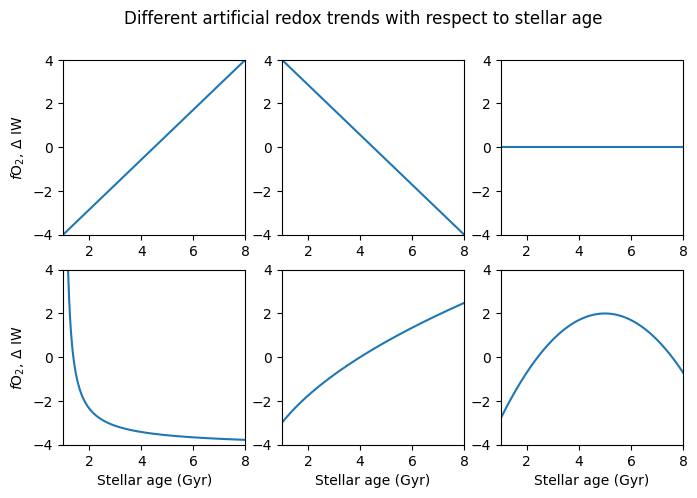

In [3]:
# define redox state function

def redox_linear(t):
    x = [1,8]
    y = [-4,4]
    return np.interp(t,x,y)

def redox_minlinear(t):
    x = [1,8]
    y = [4,-4]
    return np.interp(t,x,y)

def redox_constant(t):
    return t*0

def redox_sqrt(t):
    return 3*(t**0.5-2)

def redox_inverse(t):
    return 1.5*(1/np.log(t)-3)

def redox_parabola(t):
    return -0.3*(t-5)**2+2

def redox_oxidized(t):
    return np.random.uniform(1.33,4)

def redox_reduced(t):
    return np.random.uniform(-4,-1.33)

time = np.linspace(1,8,1000)
fig = figure(figsize=(8,5))
frame1 = fig.add_subplot(2,3,1)
frame1.plot(time,redox_linear(time))
frame1.set_xlim(1,8)
frame1.set_ylim(-4,4)
# frame1.set_xlabel('stellar age (Gyr)')
frame1.set_ylabel('$f$O$_2$, $\Delta$ IW')

frame2 = fig.add_subplot(2,3,2)
frame2.plot(time,redox_minlinear(time))
frame2.set_xlim(1,8)
frame2.set_ylim(-4,4)
# frame2.set_xlabel('stellar age (Gyr)')
# frame2.set_ylabel('fo2 (IW)')

frame3 = fig.add_subplot(2,3,3)
frame3.plot(time,redox_constant(time))
frame3.set_xlim(1,8)
frame3.set_ylim(-4,4)
# frame3.set_xlabel('stellar age (Gyr)')
# frame3.set_ylabel('fo2 (IW)')

frame4 = fig.add_subplot(2,3,4)
frame4.plot(time,redox_inverse(time))
frame4.set_xlim(1,8)
frame4.set_ylim(-4,4)
frame4.set_xlabel('Stellar age (Gyr)')
frame4.set_ylabel('$f$O$_2$, $\Delta$ IW')


frame5 = fig.add_subplot(2,3,5)
frame5.plot(time,redox_sqrt(time))
frame5.set_xlim(1,8)
frame5.set_ylim(-4,4)
frame5.set_xlabel('Stellar age (Gyr)')
# frame5.set_ylabel('fo2 (IW)')


frame6 = fig.add_subplot(2,3,6)
frame6.plot(time,redox_parabola(time))
frame6.set_xlim(1,8)
frame6.set_ylim(-4,4)
frame6.set_xlabel('Stellar age (Gyr)')
#frame6.set_ylabel('fo2 (IW)')

fig.suptitle('Different artificial redox trends with respect to stellar age')
show()


In [4]:
### define HZ functions

def check_optimistic_HZ(Rp,Ts,Fp):
    Teff = Ts - 5780
    if Rp > 1.5:
        return False
    elif Rp < 0.5:
        return False
    elif Fp < (0.320 + 5.547e-5 * Ts + 1.526e-9 * Ts**2 - 2.874e-12 * Ts**3 - 5.011e-16 * Ts**4):
        return False
    elif Fp > (1.776 + 2.136e-4 * Ts +  2.533e-8 * Ts**2 - 1.332e-11 * Ts**3 - 3.097e-15 * Ts**4):
        return False
    else:
        return True

### select different universes from p_pop data

data = np.genfromtxt("../output/planet_population.txt",skip_header=2)
titles = np.genfromtxt("../output/planet_population.txt",dtype='str')[1]

# do stellar types separately because genfromtxt can't handle floats and strings at the same time
stellartypes = np.genfromtxt("../output/planet_population.txt",skip_header=2,usecols=25,dtype=str)

# find splits in data
splits = []
testnumber = 0
for i in range(len(data)):
    if data[i][0] != testnumber:
        testnumber = data[i][0]
        splits.append(i)

### define function for generating planet table, to be used for survey

def survey_table(ppop_data=data,ppop_stellartypes=stellartypes,select_universe=0,redoxfunction="reduced",use_HZ="no"):
    # select universe
    if select_universe == 0:
        universe = ppop_data[:splits[select_universe]]
        stellartypes = ppop_stellartypes[:splits[select_universe]]
    else:
        universe = ppop_data[splits[select_universe-1]:splits[select_universe]]
        stellartypes = ppop_stellartypes[splits[select_universe-1]:splits[select_universe]]

    # make population table: distance, planet_radius, incident host flux, stellar temperature, stellar type, age, true redox state, true CH ratio
    planet_population = []
    for i in range(len(universe)):
        age = random_age(1)[0]
        CHratio = np.random.uniform(0.5,3)
        if redoxfunction == "reduced":
            redoxstate = redox_reduced(age)
        elif redoxfunction == "oxidized":
            redoxstate = redox_oxidized(age)
        planet_population.append([universe[i][24],universe[i][1],universe[i][17],universe[i][23],stellartypes[i],age,redoxstate,CHratio])

    planet_population = sorted(planet_population)

    # assign atmospheres:
    distances = [5,10,15,20]
    CHratios = [0.5,1.33,2.17,3.0]
    redoxstates = [-4.0,-1.33,1.33,4.0]
    for i in range(len(planet_population)):
        distance = planet_population[i][0]
        CHratio = planet_population[i][7]
        redoxstate = planet_population[i][6]
        distancematch = min(distances, key=lambda x:abs(x-distance))
        CHratiomatch = min(CHratios, key=lambda x:abs(x-CHratio))
        redoxstatematch = min(redoxstates, key=lambda x:abs(x-redoxstate))
        atmosphere_index = str(redoxstatematch) + "_" + str(CHratiomatch) + "_" + str(distancematch)
        planet_population[i].append(atmosphere_index)

    if use_HZ == "no":
        return planet_population
    elif use_HZ == "optimistic":
        HZ_indices = []
        for i in range(len(planet_population)):
            if check_optimistic_HZ(planet_population[i][1],planet_population[i][3],planet_population[i][2]) == True:
                HZ_indices.append(i)
        planet_population = [planet_population[i] for i in HZ_indices]
        return planet_population


In [6]:
universe1 = survey_table(select_universe=0,redoxfunction="reduced",use_HZ="optimistic")

universe2 = survey_table(select_universe=1,redoxfunction="reduced", use_HZ="optimistic")

universe3 = survey_table(select_universe=2,redoxfunction="oxidized",use_HZ="optimistic")

universe4 = survey_table(select_universe=3,redoxfunction="oxidized",use_HZ="optimistic")

In [15]:
# get abundances data
data = np.genfromtxt("../output/atmospheres_mole.csv",delimiter=",",skip_header=1)
titles = np.genfromtxt("../output/atmospheres_mole.csv",delimiter=",",dtype='str')[0]

# round coordinates
for i in range(len(data)):
    data[i][0] = round(data[i][0],2)
    data[i][1] = round(data[i][1],2)

# do fake retrieval
def retrieval(planetdata,planetname,universe,universenumber="1"):
    # key species: CO2, CH4, NH3. indices 5, 7
    atmosphere_index = planetdata[8]
    splits = atmosphere_index.split("_")
    redox_key = float(splits[0])
    CH_key = float(splits[1])
    atmosphere_key = np.intersect1d(np.where(data[:,0]==redox_key),np.where(data[:,1]==CH_key))[0]
    CO2_true = data[atmosphere_key][5]
    CH4_true = data[atmosphere_key][7]
    retrieval_data = []
    CO2_retrieval = np.random.normal(CO2_true,0.2*CO2_true,1000)
    CH4_retrieval = np.random.normal(CH4_true,0.2*CH4_true,1000)

    # write to text files
    file_destination = "../output/retrievals/fakedata/universe" + universenumber + "/" + planetname + ".txt"
    with open(file_destination, 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerows(zip(CO2_retrieval,CH4_retrieval))

    return np.concatenate((CO2_retrieval[:, None], CH4_retrieval[:, None]),axis=1)


In [16]:
planet31 = retrieval(universe3[0],"planet1",universe3,"3")
# planet12 = retrieval(universe1[1],"planet1",universe1)
# planet21 = retrieval(universe2[0],"planet1",universe2)
# planet22 = retrieval(universe2[1],"planet1",universe2)

# print(universe1[0])
# print(universe1[1])
# print(universe2[0])
# print(universe2[1])

# x = plt.hist(planet11[:,1],50,cumulative=True,density=True)
# y = plt.hist(planet12[:,1],50,cumulative=True,density=True)

# Mann-Whitney test
# U1, p = mannwhitneyu(universe1_CO2_means,universe2_CO2_means)
# print(p)

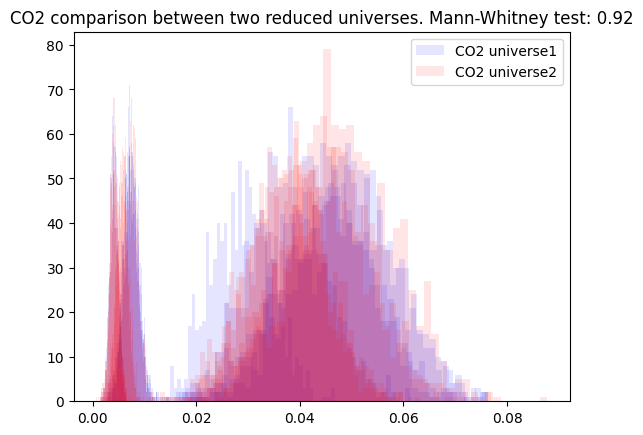

In [30]:
def plot_hist_MWtest(universe,universenumber="3",molecule="CO2",color="red"):
    universe_CO2_means = []
    universe_CH4_means = []
    for i in range(len(universe)):
        retrieval_planet = retrieval(universe[i],"planet" + str(i), universe,universenumber)
        universe_CO2_means.append(np.mean(retrieval_planet[:,0]))
        universe_CH4_means.append(np.mean(retrieval_planet[:,1]))
        if molecule == "CO2":
            plotindex = 0
        elif molecule == "CH4":
            plotindex=1
        if i == 0:
            plt.hist(retrieval_planet[:,plotindex],bins=50,alpha=0.1,color=color,label=molecule + " universe" + universenumber)
        elif i%10 == 0:
            plt.hist(retrieval_planet[:,plotindex],bins=50,alpha=0.1,color=color)
    return universe_CO2_means, universe_CH4_means

CO2_first, CH4_first = plot_hist_MWtest(universe1,"1","CO2","blue")
CO2_second, CH4_second = plot_hist_MWtest(universe2,"2","CO2","red")
U1, p = mannwhitneyu(CO2_first,CO2_second)
plt.title("CO2 comparison between two reduced universes. Mann-Whitney test: " + str(round(p,2)))
plt.legend()



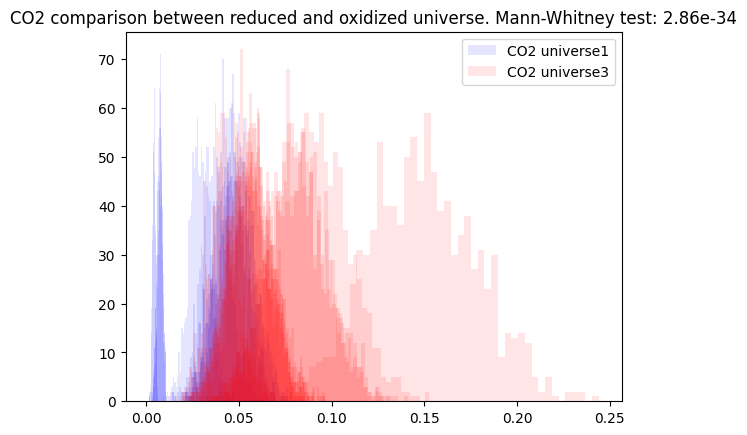

In [ ]:
CO2_first, CH4_first = plot_hist_MWtest(universe1,"1","CO2","blue")
CO2_second, CH4_second = plot_hist_MWtest(universe3,"3","CO2","red")
U1, p = mannwhitneyu(CO2_first,CO2_second)
plt.title("CO2 comparison between reduced and oxidized universe. Mann-Whitney test: " + "{:.2e}".format(p))
plt.legend()

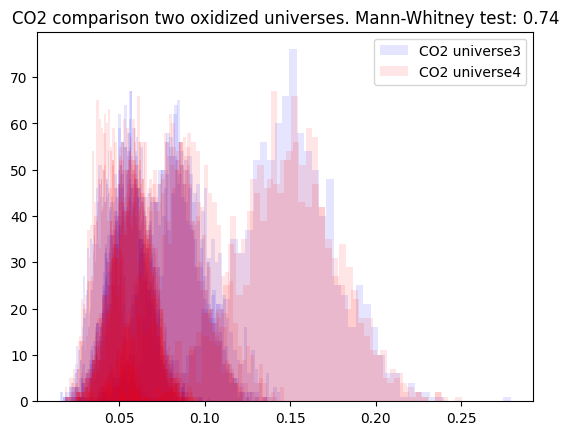

In [31]:
CO2_first, CH4_first = plot_hist_MWtest(universe3,"3","CO2","blue")
CO2_second, CH4_second = plot_hist_MWtest(universe4,"4","CO2","red")
U1, p = mannwhitneyu(CO2_first,CO2_second)
plt.title("CO2 comparison two oxidized universes. Mann-Whitney test: " + str(round(p,2)))
plt.legend()

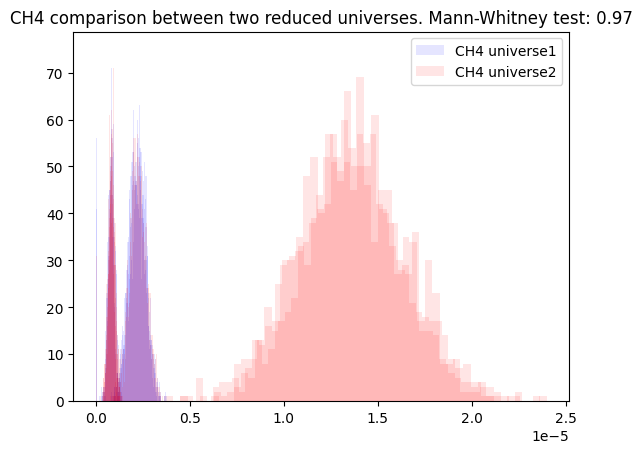

In [34]:
CO2_first, CH4_first = plot_hist_MWtest(universe1,"1","CH4","blue")
CO2_second, CH4_second = plot_hist_MWtest(universe2,"2","CH4","red")
U1, p = mannwhitneyu(CH4_first,CH4_second)
plt.title("CH4 comparison between two reduced universes. Mann-Whitney test: " + str(round(p,2)))
plt.legend()



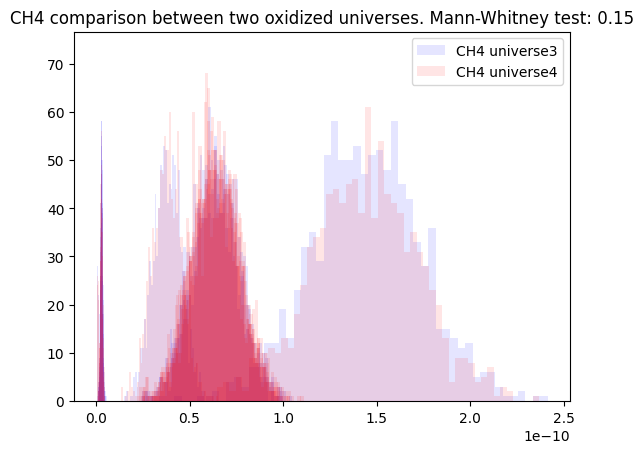

In [ ]:
CO2_first, CH4_first = plot_hist_MWtest(universe3,"3","CH4","blue")
CO2_second, CH4_second = plot_hist_MWtest(universe4,"4","CH4","red")
U1, p = mannwhitneyu(CH4_first,CH4_second)
plt.title("CH4 comparison between two oxidized universes. Mann-Whitney test: " + str(round(p,2)))
plt.legend()

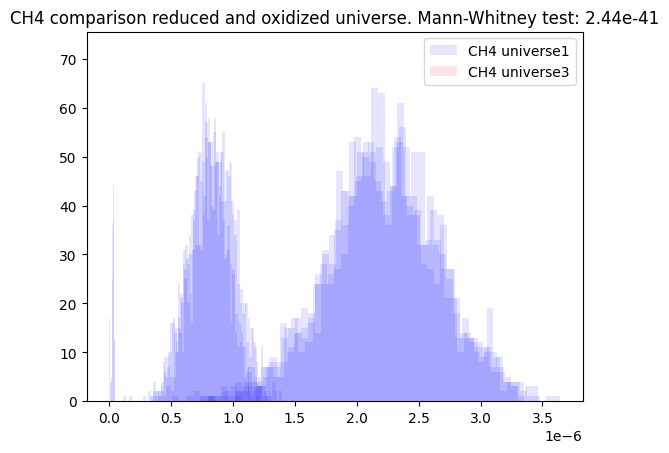

In [36]:
CO2_first, CH4_first = plot_hist_MWtest(universe1,"1","CH4","blue")
CO2_second, CH4_second = plot_hist_MWtest(universe3,"3","CH4","red")
U1, p = mannwhitneyu(CH4_first,CH4_second)
plt.title("CH4 comparison reduced and oxidized universe. Mann-Whitney test: " + "{:.2e}".format(p))
plt.legend()

